In [56]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

directory = os.path.dirname(os.path.abspath(os.getcwd()))
data_path = os.path.join(directory, "data")
file_path = os.path.join(data_path, "cr2_prAmon_2018_ghcn/cr2_prAmon_2018_ghcn.txt")

raw = pd.read_table(file_path, sep=",", index_col=0, na_values=[-9999, "-"],
                    low_memory=False)
table = raw.transpose()
groups = table.columns.to_series().groupby(table.dtypes).groups

table[table.columns.values[14:]] = table[table.columns.values[14:]].apply(pd.to_numeric)
table[['altura', 'latitud', 'longitud', 'codigo_cuenca', 'codigo_sub_cuenca', 'cantidad_observaciones']] = table[
    ['altura', 'latitud', 'longitud', 'codigo_cuenca', 'codigo_sub_cuenca', 'cantidad_observaciones']].apply(
    pd.to_numeric)
table[['inicio_observaciones', 'fin_observaciones', 'inicio_automatica']] = \
    table[['inicio_observaciones', 'fin_observaciones', 'inicio_automatica']].apply(pd.to_datetime)


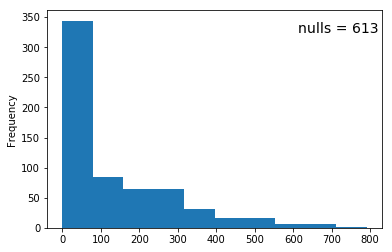

In [4]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

c = table['1995-07']
ax = c.plot.hist(use_index=True)
plt.text(0.75, 0.95, f"nulls = {c.isnull().sum()}", transform=ax.transAxes, fontsize=14,
         verticalalignment='top')
plt.show()


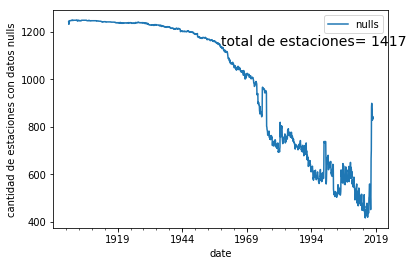

In [5]:

k = table[table.columns.values[14:]].isnull().sum()
k.index.name = 'meses'
k.index = k.index.map(lambda x: pd.Period(x))

dates = k.index.values
ts = pd.DataFrame({'date': dates,
                   'nulls': k.values}).set_index('date')
ax1 = ts.plot()
plt.text(0.5, 0.9, f"total de estaciones= {k.size}", transform=ax.transAxes, fontsize=14,
         verticalalignment='top')
ax1.set_ylabel("cantidad de estaciones con datos nulls")

plt.show()


In [6]:
def region(lat, lng):
    if lat > -27.6307621:
        return 0  # "Norte Grande"
    if lat > -32.759362:
        return 1  # "Norte Chico"
    if lat > -38.0613847:
        return 2  # "Central"
    if lat > -43.7890687:
        return 3  # "Sur"
    if lat > -56:
        return 4  # "Austral"
    else:
        return 5  # "Antartica"


def str_region(n):
    if n == 0:
        return "Norte Grande"
    if n == 1:
        return "Norte Chico"
    if n == 2:
        return "Central"
    if n == 3:
        return "Sur"
    if n == 4:
        return "Austral"
    else:
        return "Antartica"


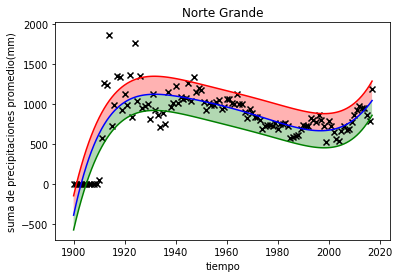

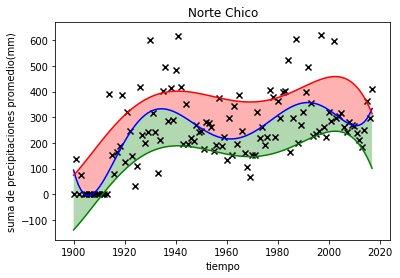

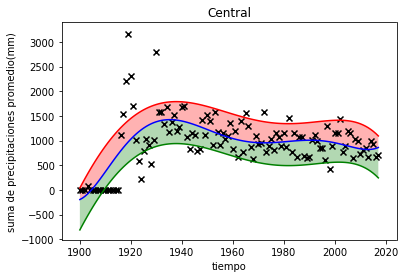

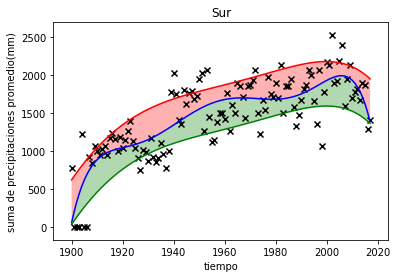

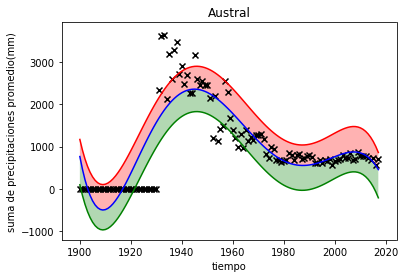

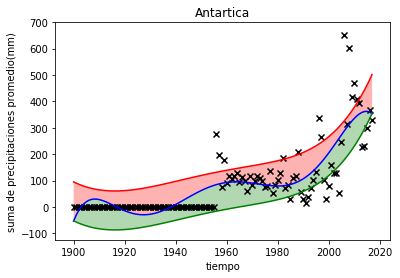

In [82]:
zona = table[['latitud', 'longitud']].apply(lambda x: region(x['latitud'], x['longitud']), axis=1)
table['zona'] = zona
import sys

def groupByYear(row):
    # print(row)
    gby = row.groupby(row.index.year,axis=0).sum()
    #print(gby)
    return gby #sys.exit(0)
    

gb = table[table.columns.values[14:]].groupby(['zona'], axis=0)
final = gb.apply(lambda x: x[14:].mean())
final.index = final['zona']
final = final.drop(['zona'], axis=1)
final.columns = final.columns.map(lambda x: pd.Period(x))
bby = final.apply(lambda x: groupByYear(x), axis = 1)

from scipy import interpolate

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

for i, row in bby.iterrows():
    # axn = row[:-1].plot()
    deg = 6
    row = row[:-1]
    z = np.polyfit(row.index, row.values,deg)
    f = np.poly1d(z)
    c1 = f(row.index)
    
    xt = row.index
    error = rmse(c1,row.values)
    c2 = c1 + error
    c3 = c1-error
    
    z1 = np.polyfit(xt, c2,deg-1)
    f1 = np.poly1d(z1)
    
    z2 = np.polyfit(xt,c3,deg-1)
    f2 = np.poly1d(z2)
    
    c4 = f1(xt)
    c5 = f2(xt)
    
    plt.plot(xt,c1,color = "b")
    plt.plot(xt,c4,color = "red")
    plt.plot(xt,c5,color = "green")
    
    plt.fill_between(xt, c1, c4, facecolor='red', interpolate=True,alpha = 0.3)
    plt.fill_between(xt, c1, c5, facecolor='green', interpolate=True, alpha = 0.3)
    
    
    plt.scatter(xt,row.values, marker = 'x', color="black")
    
    plt.title(str_region(i))
    
    plt.xlabel("tiempo")
    plt.ylabel("suma de precipitaciones promedio(mm)")
    plt.show()

In [14]:
final

codigo_estacion,1900-01,1900-02,1900-03,1900-04,1900-05,1900-06,1900-07,1900-08,1900-09,1900-10,...,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01
zona,,,,,,,,,,,,,,,,,,,,,
0.0,NaN,2.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121.273171,110.690294,78.906197,83.937755,57.908485,52.948667,118.092124,108.455701,142.606354,147.248679
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.222131,128.487395,38.328333,12.547143,42.247368,42.138390,33.230738,22.513500,25.496667,35.302979
2.0,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.261553,87.272338,151.915570,65.373871,130.974956,55.780913,62.424782,27.898261,19.854746,20.027130
3.0,86.10,35.40,48.2,99.0,54.95,56.25,81.1,67.7,44.25,93.35,...,77.104860,134.358462,186.644195,124.779703,195.943829,75.572541,143.724780,130.732528,74.756216,94.465091
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.631412,67.859118,57.711793,63.612831,57.928274,42.618500,63.872518,47.271133,56.072875,52.314198
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.183333,28.850000,26.160000,34.800000,33.316667,47.316667,18.957143,14.800000,12.300000,18.450000
